### This is similar to ML_Model_training_4.ipynb except we are using a 2:1 negative:positive data split

In [80]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier

In [81]:
train = pd.read_csv('Cleaned_data/Train_dataset.csv', index_col=0)
test = pd.read_csv('Cleaned_data/Test_dataset.csv', index_col=0)

In [82]:
train.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)
test.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)
train.head()
train['failure_actual_fail'].value_counts()

0    31277
1      836
Name: failure_actual_fail, dtype: int64

# Method 2 split data - Using train_test_split directly

In [83]:
train_features = train.drop(columns=['failure_actual_fail'])
train_y = train[['failure_actual_fail']]
test_features = test.drop(columns=['failure_actual_fail'])
test_y = test[['failure_actual_fail']]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.2, random_state = 1)

In [85]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25690, 25)
(6423, 25)
(25690, 1)
(6423, 1)


In [86]:
print(y_train['failure_actual_fail'].value_counts())
print(y_test['failure_actual_fail'].value_counts())

0    25041
1      649
Name: failure_actual_fail, dtype: int64
0    6236
1     187
Name: failure_actual_fail, dtype: int64


## Creating balanced training set (Equal fails and no fails)

In [87]:
b_train_dataset = pd.concat([X_train, y_train], axis = 1)
positives_df = b_train_dataset[b_train_dataset['failure_actual_fail'] == 1]
print(f"We have {len(positives_df)} positives")
negatives_df = b_train_dataset[b_train_dataset['failure_actual_fail'] == 0]
negatives_df_subset = negatives_df.sample(649*2, random_state=3244)
balanced_df = pd.concat([positives_df, negatives_df_subset], axis = 0)
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
X_train_balanced = balanced_df.drop(columns=['failure_actual_fail'])
y_train_balanced = balanced_df[['failure_actual_fail']]

print(X_train_balanced.shape)
print(y_train_balanced.shape)

We have 649 positives
(1947, 25)
(1947, 1)


In [88]:
y_train_balanced.value_counts()

failure_actual_fail
0                      1298
1                       649
dtype: int64

## Model building

In [89]:
from sklearn.metrics import recall_score
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

In [90]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

## Decision Trees

In [91]:
dt = DecisionTreeClassifier(random_state=1)
dt_cv = cross_val_score(dt, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(dt_cv)]}')

FNR cv_scores: [20.77, 16.15, 22.48, 25.38, 20.0]


tn: 5619, fp: 617,
fn: 49,   tp: 138
FNR: 26.2%
0.2620320855614974


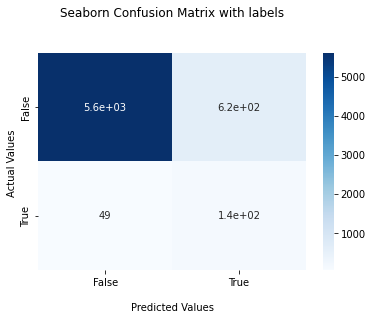

In [92]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train_balanced, y_train_balanced)
y_pred = dt.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## RF

In [93]:
rf = RandomForestClassifier(random_state=1)
rf_cv = cross_val_score(rf, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(rf_cv)]}')

FNR cv_scores: [17.69, 21.54, 31.78, 25.38, 25.38]


tn: 5910, fp: 326,
fn: 46,   tp: 141
FNR: 24.6%
0.2459893048128342


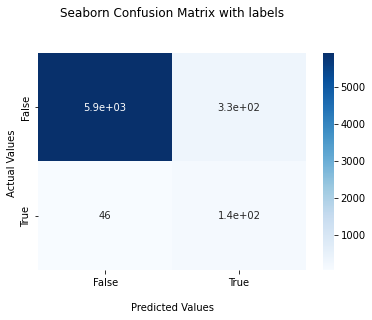

In [94]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_balanced, y_train_balanced)
y_pred = rf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## ADA

In [95]:
ada = AdaBoostClassifier(random_state=1)
ada_cv = cross_val_score(ada, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(ada_cv)]}')

FNR cv_scores: [20.0, 21.54, 24.03, 26.92, 23.08]


tn: 5711, fp: 525,
fn: 49,   tp: 138
FNR: 26.2%
0.2620320855614974


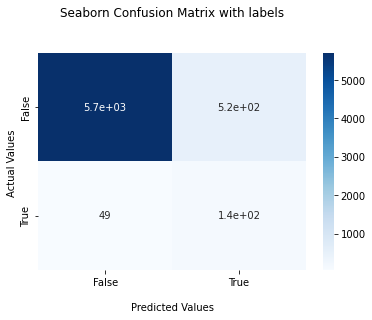

In [96]:
ada = AdaBoostClassifier(random_state=1)
ada.fit(X_train_balanced, y_train_balanced)
y_pred = ada.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## Gradient Boosting Algo

In [97]:
gb = GradientBoostingClassifier(random_state=1)
gb_cv = cross_val_score(gb, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(gb_cv)]}')

FNR cv_scores: [17.69, 20.0, 24.03, 25.38, 25.38]


tn: 5893, fp: 343,
fn: 48,   tp: 139
FNR: 25.67%
0.25668449197860965


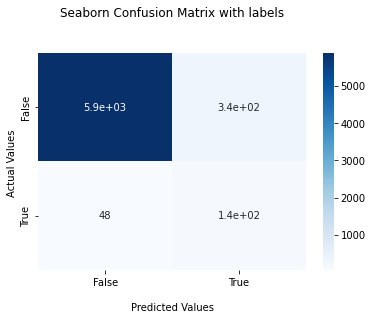

In [98]:
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_balanced, y_train_balanced)
y_pred = gb.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## XGBoost

In [99]:
xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc_cv = cross_val_score(xgbc, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(xgbc_cv)]}')

FNR cv_scores: [15.38, 18.46, 24.03, 23.85, 24.62]


tn: 5885, fp: 351,
fn: 39,   tp: 148
FNR: 20.86%
0.20855614973262027


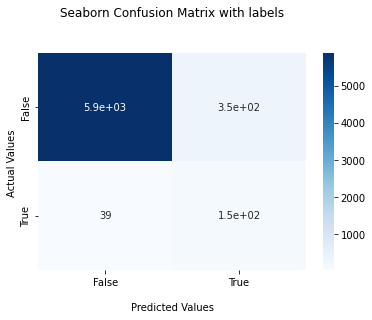

In [100]:
xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(X_train_balanced,y_train_balanced)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## Stacked

In [101]:
warnings.simplefilter('ignore')
stack_estimators = [('boost', GradientBoostingClassifier(random_state=1)),
('xgboost', xgb.XGBClassifier(random_state=1, verbosity = 0)),
('rf', RandomForestClassifier(random_state=1))]
stacked = StackingClassifier(estimators= stack_estimators, final_estimator=LogisticRegression())
stacked_cv = cross_val_score(stacked, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(stacked_cv)]}')

FNR cv_scores: [15.38, 20.0, 26.36, 25.38, 24.62]


tn: 5920, fp: 316,
fn: 45,   tp: 142
FNR: 24.06%
0.2406417112299465


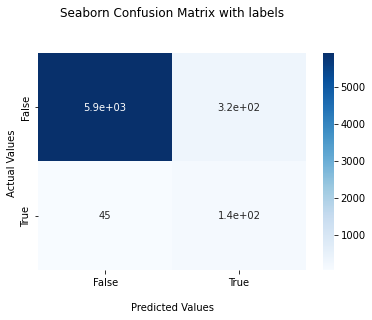

In [102]:
stack_estimators = [('boost', GradientBoostingClassifier(random_state=1)),
('xgboost', xgb.XGBClassifier(random_state=1, verbosity = 0)),
('rf', RandomForestClassifier(random_state = 1))]
stacked = StackingClassifier(estimators= stack_estimators, final_estimator=LogisticRegression())
stacked.fit(X_train_balanced, y_train_balanced)
y_pred = stacked.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## KNN

In [103]:
knn = KNeighborsClassifier()
knn_cv = cross_val_score(knn, X_train_balanced, y_train_balanced, scoring='recall', cv=5)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(knn_cv)]}')

FNR cv_scores: [100.0, 100.0, 100.0, 100.0, 100.0]


tn: 0, fp: 6236,
fn: 0,   tp: 187
FNR: 0.0%
0.0


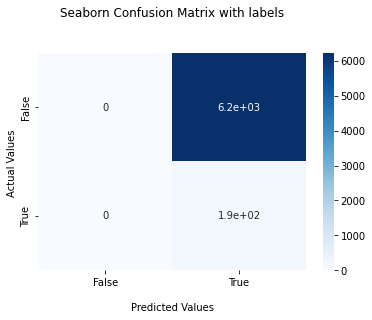

In [104]:
knn = KNeighborsClassifier()
knn.fit(X_train_balanced, y_train_balanced)
y_pred = knn.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## NB

In [105]:
nb = GaussianNB()
nb_cv = cross_val_score(nb, X_train_balanced, y_train_balanced, scoring='recall', cv=8)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(nb_cv)]}')

FNR cv_scores: [76.54, 74.07, 82.93, 82.72, 79.01, 92.59, 83.95, 86.42]


tn: 6198, fp: 38,
fn: 156,   tp: 31
FNR: 83.42%
0.8342245989304813


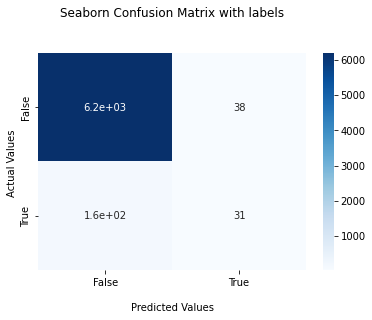

In [106]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_balanced, y_train_balanced)
y_pred = nb.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## SVC

In [107]:
svc = SVC()
svm_cv = cross_val_score(svc, X_train_balanced, y_train_balanced, scoring='recall',cv = 8)
print(f'FNR cv_scores: {[round((1-x)*100, 2) for x in list(svm_cv)]}')

FNR cv_scores: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


tn: 6236, fp: 0,
fn: 187,   tp: 0
FNR: 100.0%
1.0


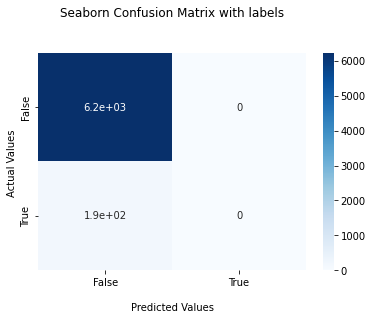

In [108]:
svc = SVC()
svc.fit(X_train_balanced, y_train_balanced)
y_pred = svc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## END (Rough notes below)

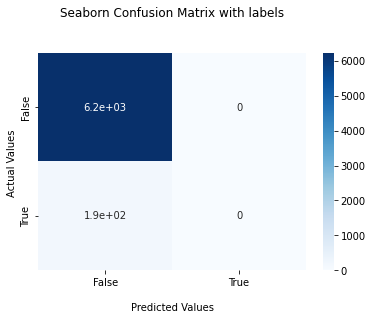

In [109]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Formula for computing the FNR (1 - Recall): 

1 - recall_score(y_test, y_pred)

In [110]:
cf_matrix

array([[6236,    0],
       [ 187,    0]], dtype=int64)

In [111]:
tn = cf_matrix[0,0]
tp = cf_matrix[1,1]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
print(tn, tp, fn, fp)
print(fn/(fn+tp))
#cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])

6236 0 187 0
1.0
